In [1]:
# Let's test prophet library on an exampl dataset for forecasting and performance tracking

In [1]:
import polars as pl
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [65]:
def prepare_data(file_path):
    # Read the CSV file into a Polars DataFrame
    df = pl.read_csv(file_path)

    # Combine year, month, day, and hour_utc to form a proper timestamp
    df = df.with_columns([
        (pl.col('year').cast(str) + '-' +
         pl.col('month').cast(str).str.zfill(2) + '-' +
         pl.col('day').cast(str).str.zfill(2) + ' ' +
         pl.col('hour_utc')).alias('timestamp_str')
    ])

    df = df.with_columns(pl.col('timestamp_str').str.strptime(pl.Datetime, format='%Y-%m-%d %H:%M').alias('timestamp'))
    df = df.drop(['year', 'month', 'day', 'hour_utc','timestamp_str'])

    return df


In [66]:

# Read the CSV file into a Polars DataFrame
df = prepare_data('../example_data/Pirita_2011_2022.csv')

In [67]:
df.describe

<bound method DataFrame.describe of shape: (105_192, 7)
┌──────────┬──────────┬──────────┬─────┬────────┬─────────┬─────────────────────┐
│ temp_avg ┆ temp_min ┆ temp_max ┆ twd ┆ tws_ms ┆ tws_max ┆ timestamp           │
│ ---      ┆ ---      ┆ ---      ┆ --- ┆ ---    ┆ ---     ┆ ---                 │
│ f64      ┆ f64      ┆ f64      ┆ i64 ┆ f64    ┆ f64     ┆ datetime[μs]        │
╞══════════╪══════════╪══════════╪═════╪════════╪═════════╪═════════════════════╡
│ -3.4     ┆ -3.9     ┆ -3.4     ┆ 150 ┆ 5.7    ┆ 9.0     ┆ 2011-01-01 00:00:00 │
│ -2.8     ┆ -3.4     ┆ -2.8     ┆ 158 ┆ 6.3    ┆ 9.0     ┆ 2011-01-01 01:00:00 │
│ -2.4     ┆ -2.8     ┆ -2.4     ┆ 151 ┆ 5.7    ┆ 9.4     ┆ 2011-01-01 02:00:00 │
│ -2.4     ┆ -2.5     ┆ -2.4     ┆ 144 ┆ 5.7    ┆ 9.3     ┆ 2011-01-01 03:00:00 │
│ -2.5     ┆ -2.6     ┆ -2.4     ┆ 130 ┆ 6.1    ┆ 8.9     ┆ 2011-01-01 04:00:00 │
│ …        ┆ …        ┆ …        ┆ …   ┆ …      ┆ …       ┆ …                   │
│ 6.0      ┆ 5.8      ┆ 6.0      ┆ 214 ┆ 1

In [25]:
# def prepare_air_data():
#     # Read the CSV file into a Polars DataFrame
#     df = pl.read_csv('../example_data/AirPassengers.csv')

#     df = df.with_columns(pl.col('date').str.strptime(pl.Datetime, format='%Y-%m-%d').alias('timestamp'))
#     df = df.drop(['date'])

#     return df


In [30]:
# df  = prepare_air_data()
# df.describe

<bound method DataFrame.describe of shape: (144, 2)
┌─────┬─────────────────────┐
│ y   ┆ timestamp           │
│ --- ┆ ---                 │
│ i64 ┆ datetime[μs]        │
╞═════╪═════════════════════╡
│ 112 ┆ 1949-01-01 00:00:00 │
│ 118 ┆ 1949-02-01 00:00:00 │
│ 132 ┆ 1949-03-01 00:00:00 │
│ 129 ┆ 1949-04-01 00:00:00 │
│ 121 ┆ 1949-05-01 00:00:00 │
│ …   ┆ …                   │
│ 606 ┆ 1960-08-01 00:00:00 │
│ 508 ┆ 1960-09-01 00:00:00 │
│ 461 ┆ 1960-10-01 00:00:00 │
│ 390 ┆ 1960-11-01 00:00:00 │
│ 432 ┆ 1960-12-01 00:00:00 │
└─────┴─────────────────────┘>

In [68]:
def create_continuous_df(df):
    # Ensure the timeline is continuous and fill missing hourly data with nulls
    start_date = df['timestamp'].min()

    #start_date = datetime.strptime('2021-01-01', '%Y-%m-%d')

    end_date = df['timestamp'].max()

    # Create a continuous range of timestamps using polars
    df_hours = pl.datetime_range(start_date, end_date, "1d", eager=True).alias("timestamp")

    # Convert the Series to a DataFrame
    continuous_df = df_hours.to_frame()

    # Join the continuous timestamps with the original data
    continuous_df = continuous_df.join(df, on='timestamp', how='left', coalesce=True)

    return continuous_df

In [69]:
#df_cont = create_continuous_df(df)
df_cont = df

In [70]:
df_cont.describe

<bound method DataFrame.describe of shape: (105_192, 7)
┌──────────┬──────────┬──────────┬─────┬────────┬─────────┬─────────────────────┐
│ temp_avg ┆ temp_min ┆ temp_max ┆ twd ┆ tws_ms ┆ tws_max ┆ timestamp           │
│ ---      ┆ ---      ┆ ---      ┆ --- ┆ ---    ┆ ---     ┆ ---                 │
│ f64      ┆ f64      ┆ f64      ┆ i64 ┆ f64    ┆ f64     ┆ datetime[μs]        │
╞══════════╪══════════╪══════════╪═════╪════════╪═════════╪═════════════════════╡
│ -3.4     ┆ -3.9     ┆ -3.4     ┆ 150 ┆ 5.7    ┆ 9.0     ┆ 2011-01-01 00:00:00 │
│ -2.8     ┆ -3.4     ┆ -2.8     ┆ 158 ┆ 6.3    ┆ 9.0     ┆ 2011-01-01 01:00:00 │
│ -2.4     ┆ -2.8     ┆ -2.4     ┆ 151 ┆ 5.7    ┆ 9.4     ┆ 2011-01-01 02:00:00 │
│ -2.4     ┆ -2.5     ┆ -2.4     ┆ 144 ┆ 5.7    ┆ 9.3     ┆ 2011-01-01 03:00:00 │
│ -2.5     ┆ -2.6     ┆ -2.4     ┆ 130 ┆ 6.1    ┆ 8.9     ┆ 2011-01-01 04:00:00 │
│ …        ┆ …        ┆ …        ┆ …   ┆ …      ┆ …       ┆ …                   │
│ 6.0      ┆ 5.8      ┆ 6.0      ┆ 214 ┆ 1

In [81]:
def fit_and_plot_prophet(continuous_df, start_time, lookback_hours, lookahead_hours, column_name, plot_lookback_hours):
    # Select the lookback window for fitting
    lookback_start_date = start_time - timedelta(hours=lookback_hours)
    lookback_df = continuous_df.filter(pl.col('timestamp') >= lookback_start_date)

    # Prepare data for Prophet
    prophet_df = lookback_df.select(['timestamp', column_name]).rename({
        'timestamp': 'ds',
        column_name: 'y'
    }).to_pandas()

    # Fit the Prophet model with yearly seasonality
    model = Prophet(yearly_seasonality=False, daily_seasonality=True, weekly_seasonality=False,changepoint_prior_scale=0.01)
    model.fit(prophet_df)

    # Create a dataframe for future predictions (lookahead window)
    future = model.make_future_dataframe(periods=lookahead_hours, freq='h')
    forecast = model.predict(future)
    
  
    # Define the plot window start time
    plot_start_time = start_time - timedelta(hours=plot_lookback_hours)
    plot_end_time = start_time + timedelta(hours=lookahead_hours)

    # Plot the results using Prophet's plotting functions
    fig = model.plot(forecast)
    ax = fig.gca()

    # Set the x-axis limit to the plot window start time
    ax.set_xlim([plot_start_time, plot_end_time])

    # Merge forecast with original data to find outliers
    merged_df = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].set_index('ds').join(prophet_df.set_index('ds'))

    # Identify outliers
    outliers = merged_df[(merged_df['y'] < merged_df['yhat_lower']) | (merged_df['y'] > merged_df['yhat_upper'])]

    # Plot the original data points
    ax.plot(prophet_df['ds'], prophet_df['y'], 'k.', label='Data')

    # Highlight outliers
    ax.scatter(outliers.index, outliers['y'], color='red', s=10, label='Outliers')
    ax.legend()

    # Add a vertical line for the start_time
    ax.axvline(x=start_time, color='blue', linestyle='--', linewidth=2, label='Start Time')

    # Add title and labels
    ax.set_title(f'{column_name} Forecast')
    ax.set_xlabel('Timestamp')
    ax.set_ylabel(column_name)

    plt.show()

    # Plot the seasonal components
    fig = model.plot_components(forecast)
    plt.show()


00:51:24 - cmdstanpy - INFO - Chain [1] start processing
00:51:27 - cmdstanpy - INFO - Chain [1] done processing
/home/siimt/anaconda3/envs/timeseries-forecasting/lib/python3.11/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/home/siimt/anaconda3/envs/timeseries-forecasting/lib/python3.11/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


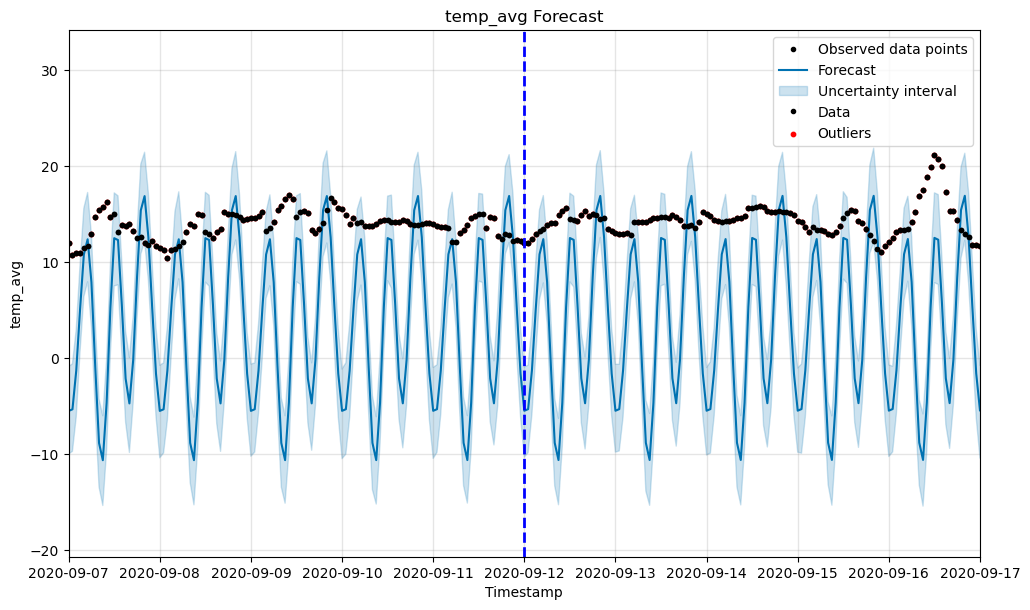

/home/siimt/anaconda3/envs/timeseries-forecasting/lib/python3.11/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/home/siimt/anaconda3/envs/timeseries-forecasting/lib/python3.11/site-packages/prophet/plot.py:397: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  artists += ax.plot(df_y['ds'].dt.to_pydatetime(), seas[name], ls='-',
/home/siimt/anaconda3/envs/timeseries-forecasting/lib/python3.11/site-packages/prophet/plot.py:401: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this w

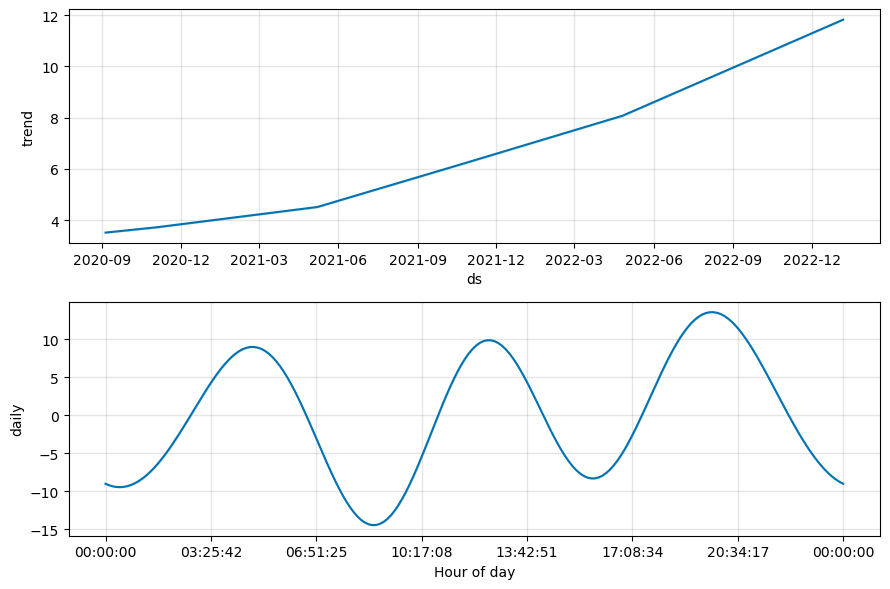

In [89]:
# Define the parameters
#start_time = df_cont['timestamp'].max()  # Use the last available timestamp as the start time
start_time = datetime.strptime('2020-09-12', '%Y-%m-%d')
lookback_hours = 24*7
lookahead_hours = 24*5
plot_lookaback_hours = 24*5
column_name = 'temp_avg'
# Fit the model and plot the results
fit_and_plot_prophet(df_cont, start_time, lookback_hours, lookahead_hours, column_name,plot_lookaback_hours)